In [10]:
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Load the JSON data
with open("./results/text_pooling_results.json") as f:
    data = json.load(f)

# Function to flatten nested dictionary (dataset_params and model_params)
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Function to process the JSON data into a DataFrame
def process_data(data):
    rows = []
    for entry in data:
        # Flatten model_params and dataset_params and combine them
        flattened_params = {**flatten_dict(entry["model_params"]), **flatten_dict(entry["dataset_params"])}
        
        # Add train and validation metrics
        train_metrics = entry["train_metrics"]
        val_metrics = entry["val_metrics"]

        for epoch in range(entry["epochs"]):
            row = {
                'epoch': epoch + 1,
                'train_loss': train_metrics['loss'][epoch],
                'train_accuracy': train_metrics['accuracy'][epoch],
                'train_f1': train_metrics['f1'][epoch],
                'val_loss': val_metrics['loss'][epoch],
                'val_accuracy': val_metrics['accuracy'][epoch],
                'val_f1': val_metrics['f1'][epoch],
            }
            row.update(flattened_params)  # Include all flattened parameters in the row
            rows.append(row)
    
    df = pd.DataFrame(rows)
    # Convert unhashable types (lists, dictionaries, etc.) into strings for pivoting
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (list, dict, tuple))).any():
            df[col] = df[col].apply(lambda x: str(x))  # Convert to string
    
    return df

# Convert the JSON data to a DataFrame
df = process_data(data)

# Get all unique parameter names (excluding metric columns)
pivot_options = [col for col in df.columns if col not in ['epoch', 'train_loss', 'train_accuracy', 'train_f1', 'val_loss', 'val_accuracy', 'val_f1']]

# Create a Dash app for interactive plotting
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Model Training Metrics"),
    
    # Dropdown for selecting the metric to display
    html.Label("Choose a Metric:"),
    dcc.Dropdown(
        id="metric",
        options=[
            {'label': 'Loss', 'value': 'loss'},
            {'label': 'Accuracy', 'value': 'accuracy'},
            {'label': 'F1 Score', 'value': 'f1'},
        ],
        value='loss'
    ),
    
    # Dropdown for selecting the hyperparameter to pivot over (dynamic based on dataset)
    html.Label("Choose a Hyperparameter to Pivot Over:"),
    dcc.Dropdown(
        id="pivot_by",
        options=[{'label': str(col).replace('_', ' ').capitalize(), 'value': str(col)} for col in pivot_options],
        value='learning_rate'
    ),

    # Toggle to switch between individual, summary, and comparison view
    dcc.RadioItems(
        id='view_mode',
        options=[
            {'label': 'Individual', 'value': 'individual'},
            {'label': 'Summary', 'value': 'summary'},
            {'label': 'Comparison', 'value': 'comparison'}
        ],
        value='individual',
        labelStyle={'display': 'inline-block'}
    ),
    
    # Plot for training metrics
    dcc.Graph(id='train_metric_graph'),
    
    # Plot for validation metrics
    dcc.Graph(id='val_metric_graph')
])

@app.callback(
    [Output('train_metric_graph', 'figure'),
     Output('val_metric_graph', 'figure')],
    [Input('metric', 'value'),
     Input('pivot_by', 'value'),
     Input('view_mode', 'value')]
)
def update_graph(selected_metric, pivot_by, view_mode):
    train_metric_col = f"train_{selected_metric}"
    val_metric_col = f"val_{selected_metric}"

    if view_mode == 'summary':
        summary_df = df.groupby(['epoch', pivot_by]).agg(
            min_train_metric=(train_metric_col, 'min'),
            min_val_metric=(val_metric_col, 'min'),
        ).reset_index()

        # Prepare figure for training metrics
        train_fig = go.Figure()

        unique_pivot_vals = summary_df[pivot_by].unique()
        color_map = px.colors.qualitative.Plotly[:len(unique_pivot_vals)]

        for i, val in enumerate(unique_pivot_vals):
            pivot_group = summary_df[summary_df[pivot_by] == val]

            train_fig.add_trace(go.Scatter(
                x=pivot_group['epoch'],
                y=pivot_group['min_train_metric'],
                mode='lines',
                name=f'Min Train ({val})',
                line=dict(color=color_map[i], dash='dash')
            ))

        train_fig.update_layout(
            title=f"Train {selected_metric.capitalize()} Summary Over Epochs",
            xaxis_title="Epoch",
            yaxis_title=f"Train {selected_metric.capitalize()}"
        )

        # Prepare figure for validation metrics
        val_fig = go.Figure()

        for i, val in enumerate(unique_pivot_vals):
            pivot_group = summary_df[summary_df[pivot_by] == val]

            val_fig.add_trace(go.Scatter(
                x=pivot_group['epoch'],
                y=pivot_group['min_val_metric'],
                mode='lines',
                name=f'Min Val ({val})',
                line=dict(color=color_map[i], dash='dash')
            ))

        val_fig.update_layout(
            title=f"Validation {selected_metric.capitalize()} Summary Over Epochs",
            xaxis_title="Epoch",
            yaxis_title=f"Validation {selected_metric.capitalize()}"
        )

    elif view_mode == 'comparison':
        # Exclude columns that contain lists or unhashable types
        comparison_cols = [col for col in df.columns if col not in ['epoch', train_metric_col, val_metric_col, pivot_by] and not isinstance(df[col].iloc[0], list)]

        # Filter out cases where only the pivot_by value differs
        comparison_df = df.groupby(comparison_cols).filter(lambda x: x[pivot_by].nunique() > 1)

        train_fig = px.line(comparison_df, x="epoch", y=train_metric_col, color=pivot_by, markers=True,
                            labels={
                                "epoch": "Epoch",
                                train_metric_col: f"Train {selected_metric.capitalize()}",
                                pivot_by: pivot_by.replace("_", " ").capitalize()
                            },
                            title=f"Train {selected_metric.capitalize()} Comparison Over Epochs")
        
        val_fig = px.line(comparison_df, x="epoch", y=val_metric_col, color=pivot_by, markers=True,
                        labels={
                            "epoch": "Epoch",
                            val_metric_col: f"Validation {selected_metric.capitalize()}",
                            pivot_by: pivot_by.replace("_", " ").capitalize()
                        },
                        title=f"Validation {selected_metric.capitalize()} Comparison Over Epochs")


    else:  # Individual mode
        # Plot for training metrics (individual performance)
        train_fig = px.line(df, x="epoch", y=train_metric_col, color=pivot_by, markers=True,
                            labels={
                                "epoch": "Epoch",
                                train_metric_col: f"Train {selected_metric.capitalize()}",
                                pivot_by: pivot_by.replace("_", " ").capitalize()
                            },
                            title=f"Train {selected_metric.capitalize()} Over Epochs")
        
        # Plot for validation metrics (individual performance)
        val_fig = px.line(df, x="epoch", y=val_metric_col, color=pivot_by, markers=True,
                          labels={
                              "epoch": "Epoch",
                              val_metric_col: f"Validation {selected_metric.capitalize()}",
                              pivot_by: pivot_by.replace("_", " ").capitalize()
                          },
                          title=f"Validation {selected_metric.capitalize()} Over Epochs")

    return train_fig, val_fig

if __name__ == '__main__':
    app.run_server(debug=True)


# Static Plots

Plotting results for dataset: stock_net


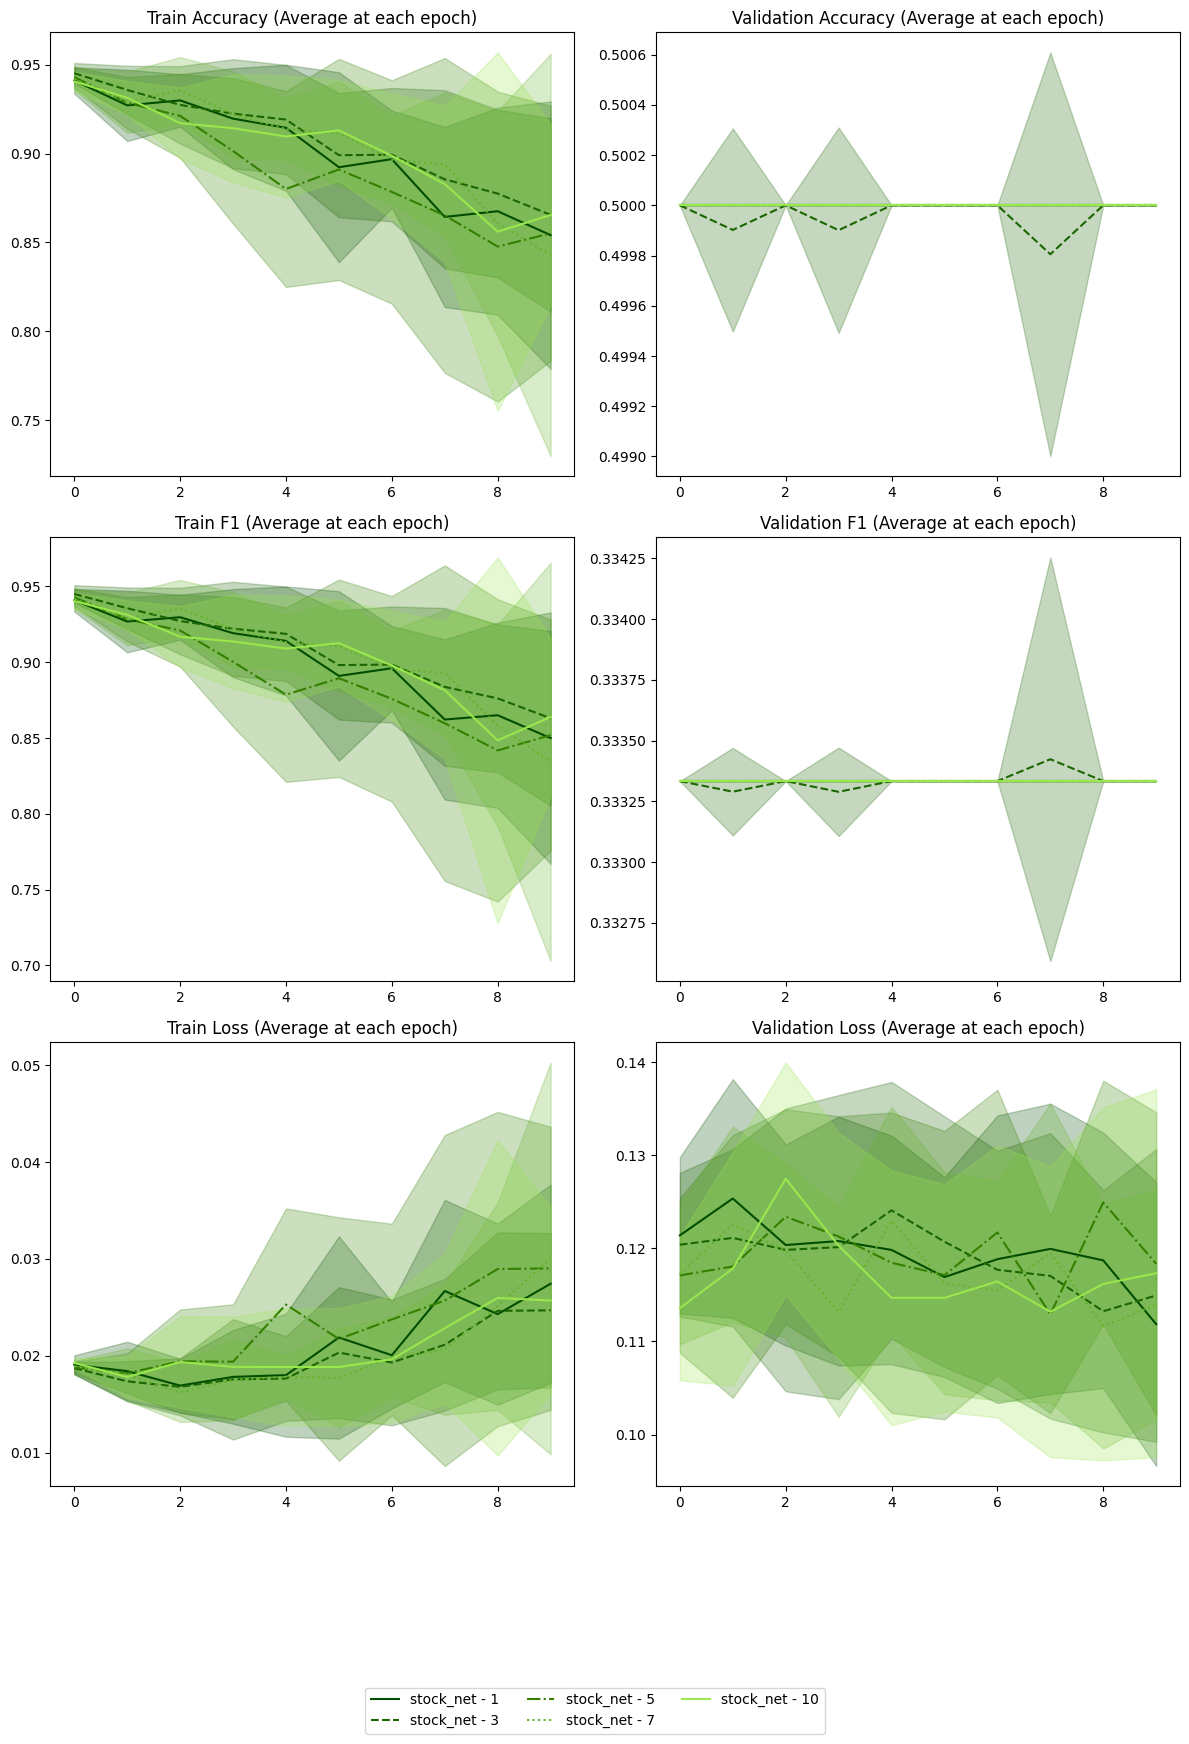

Plotting results for dataset: stock_emotion


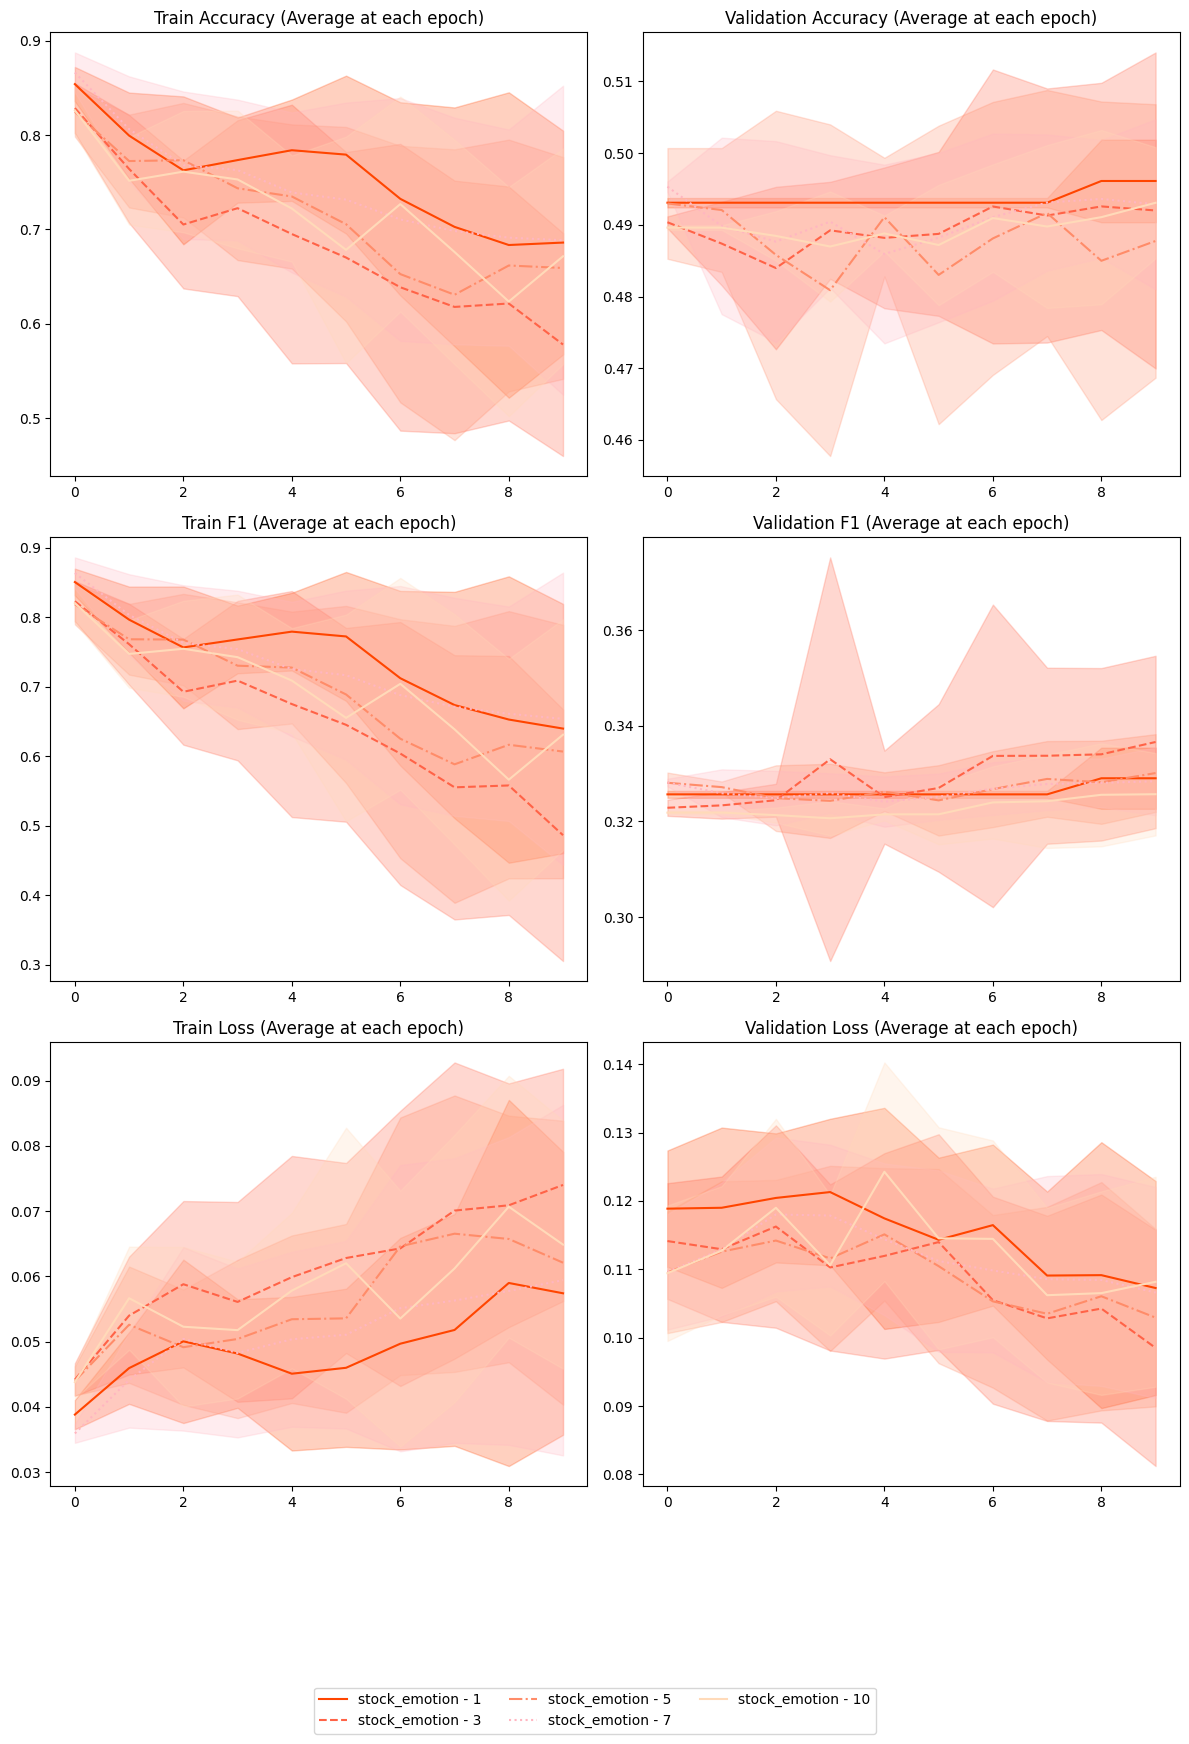

Plotting results for dataset: EDT


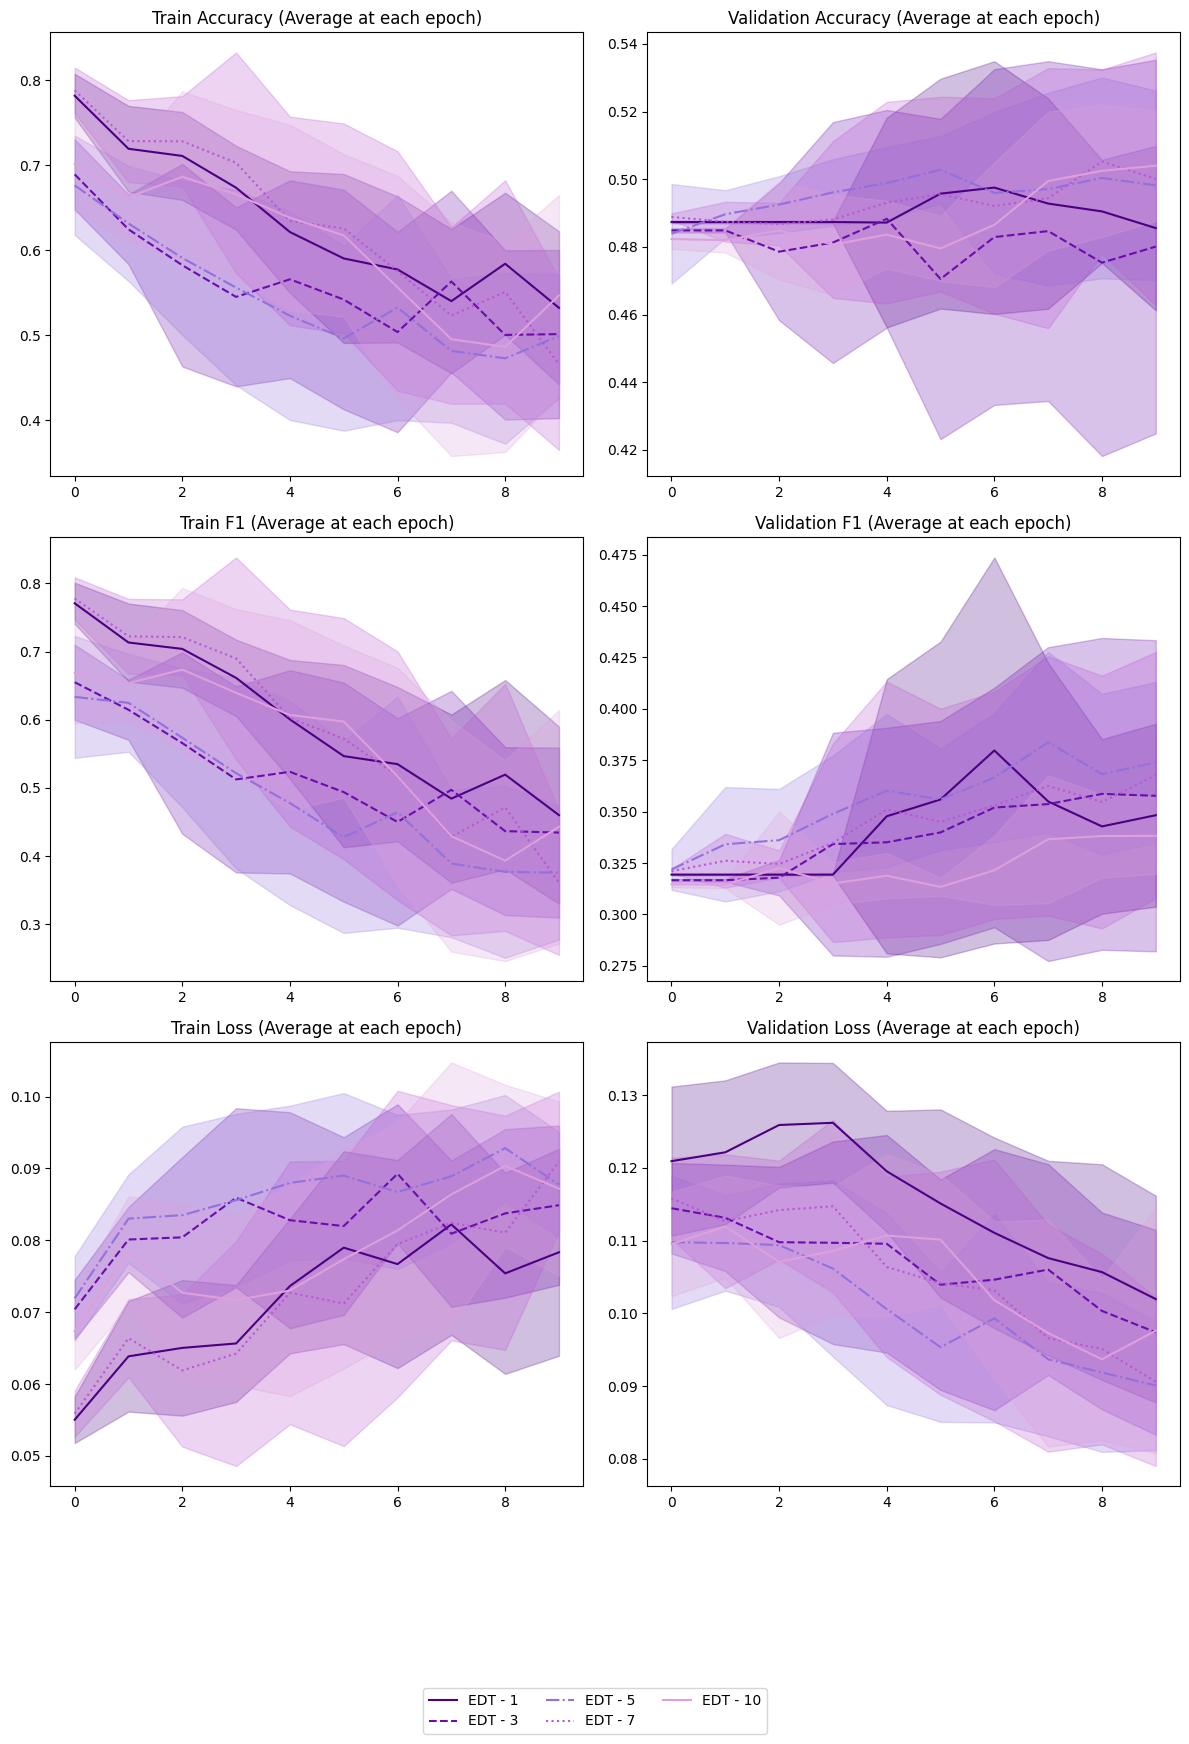

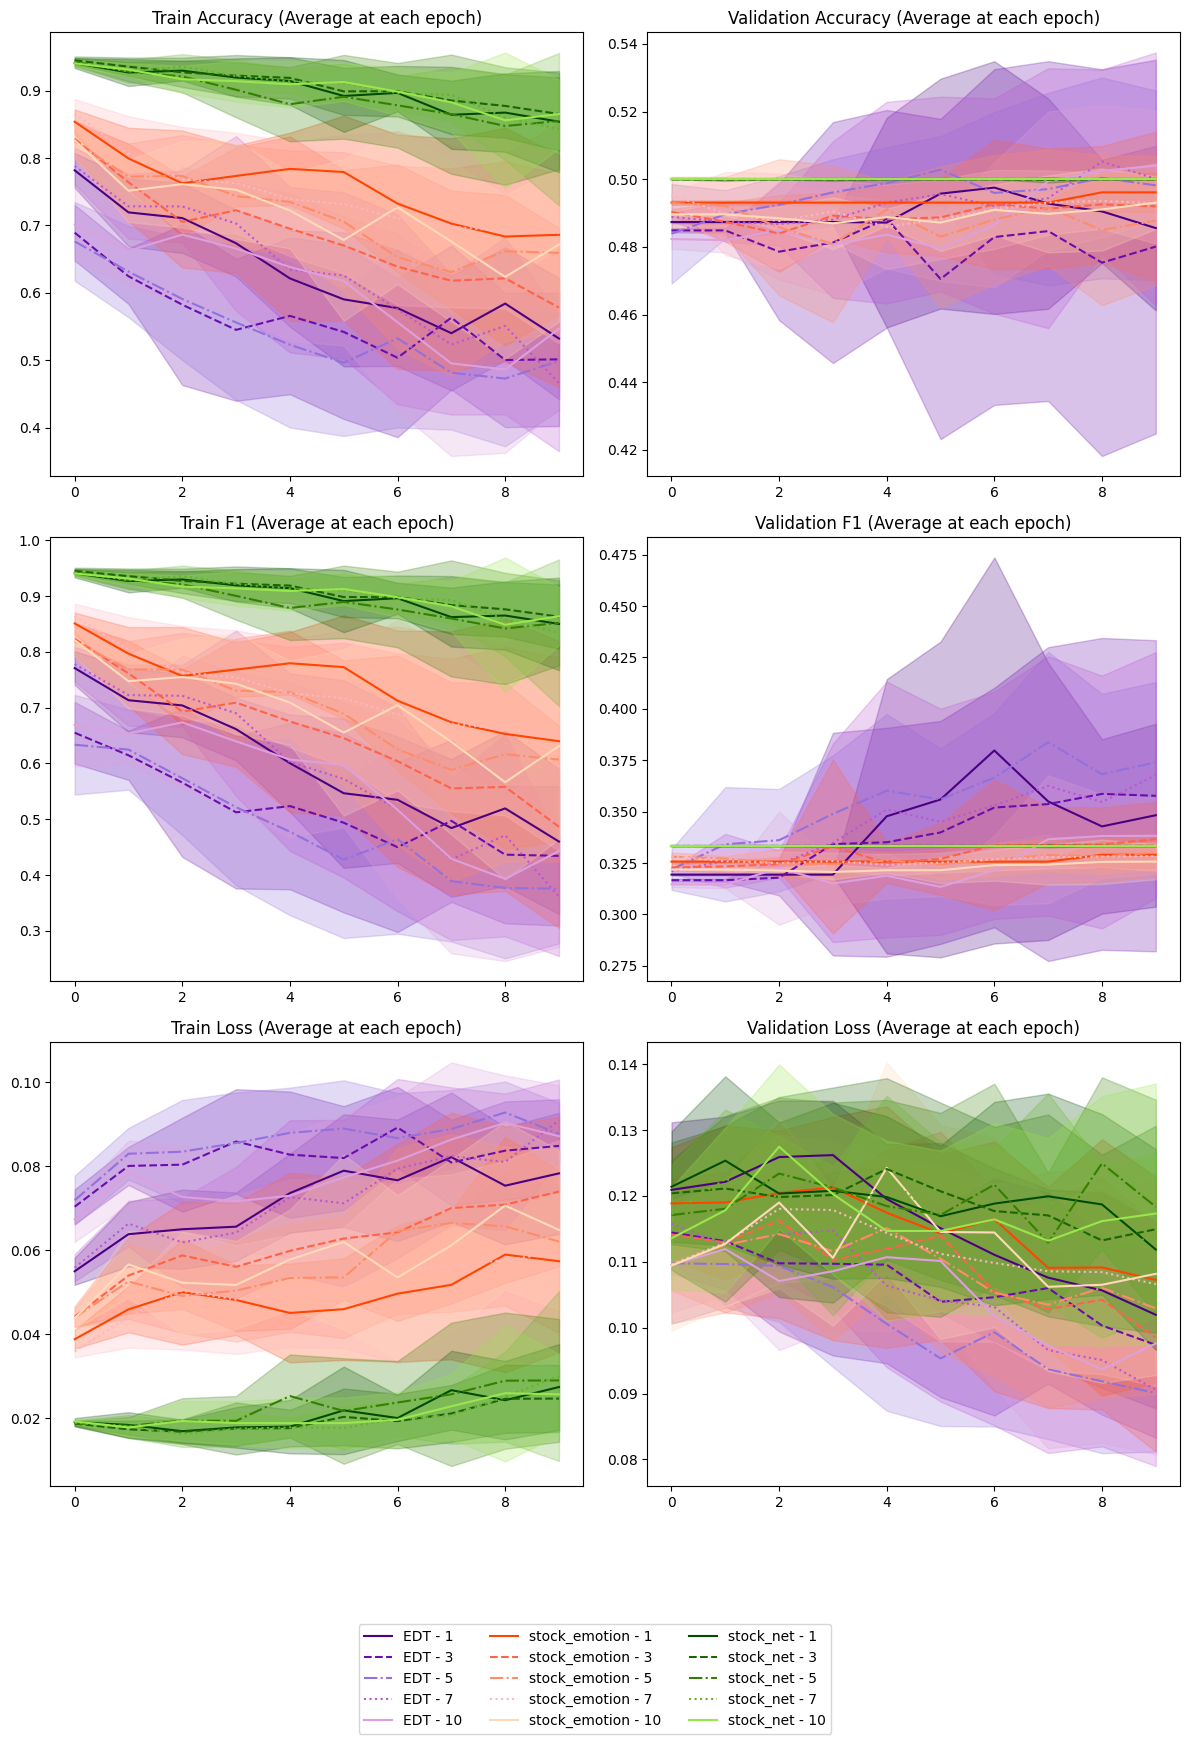

In [52]:
# Updating the plotting function to include legend based on dataset_name and text_aggregation_method
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON file data
file_path = "./results/window_results.json"
with open(file_path, "r") as file:
    data = json.load(file)




# Visualize confusion matrices for training and validation
def plot_confusion_matrices(data):
    for i, entry in enumerate(data[:3]):  # Limiting to first 3 examples for demonstration
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        train_conf_matrix = np.array(entry['train_metrics']['conf_matrix'][-1])
        val_conf_matrix = np.array(entry['val_metrics']['conf_matrix'][-1])

        sns.heatmap(train_conf_matrix, annot=True, fmt='d', ax=ax[0], cmap='Blues')
        ax[0].set_title(f'Train Confusion Matrix (Index {entry["search_index"]})')
        ax[0].set_xlabel('Predicted')
        ax[0].set_ylabel('True')

        sns.heatmap(val_conf_matrix, annot=True, fmt='d', ax=ax[1], cmap='Blues')
        ax[1].set_title(f'Validation Confusion Matrix (Index {entry["search_index"]})')
        ax[1].set_xlabel('Predicted')
        ax[1].set_ylabel('True')

        plt.tight_layout()
        plt.show()


# Calculate mean, variance, and standard deviation
def compute_run_stats(runs):
    stats = {}
    
    metrics = ['accuracy', 'f1', 'loss']
    
    for metric in metrics:
        train_values = np.array([entry['train_metrics'][metric] for entry in runs])
        val_values = np.array([entry['val_metrics'][metric] for entry in runs])
        
        stats[f'train_{metric}_mean'] = np.mean(train_values, axis=0)
        stats[f'train_{metric}_std'] = np.std(train_values, axis=0)
        stats[f'train_{metric}_var'] = np.var(train_values, axis=0)
        
        stats[f'val_{metric}_mean'] = np.mean(val_values, axis=0)
        stats[f'val_{metric}_std'] = np.std(val_values, axis=0)
        stats[f'val_{metric}_var'] = np.var(val_values, axis=0)
    
    return stats


import matplotlib.colors as mcolors

color_sets = {
    # Gradient from dark green to light green for 'stock_net'
    'stock_net': ['#004d00', '#1a6600', '#338000', '#66b32d', '#99e64d'],  

    # Gradient from dark purple to light purple for 'EDT'
    'EDT': ['#4B0082', '#6A0DAD', '#9370DB', '#BA55D3', '#DDA0DD'],      

    # Gradient from dark orange to pale red for 'stock_emotion'
    'stock_emotion': ['#FF4500', '#FF6347', '#FF8C69', '#FFB6C1', '#FFDAB9']
}

# Function to select a color from predefined color sets based on the dataset
def get_color_variations_improved(base_dataset, num_variations, current_index):
    # Use the corresponding color set for the dataset
    color_list = color_sets[base_dataset]
    
    # If there are more variations than available colors, repeat colors
    # Select the color based on the index of the current parameter (current_index)
    return color_list[current_index % len(color_list)]

# Function to dynamically map line styles based on unique values of a parameter
def get_dynamic_line_styles(param_values):
    styles = ['-', '--', '-.', ':']
    unique_params = list(set(param_values))  # Get unique values of the parameter
    return {param: styles[i % len(styles)] for i, param in enumerate(unique_params)}

# Helper function to convert non-hashable types (lists, dicts) to tuples
def make_hashable(value):
    if isinstance(value, (list, dict)):
        return tuple(value)
    return value

# Adjusting the plot function to handle colors, line styles, and correct the legend dynamically
def plot_metrics_with_predefined_colors_and_styles(data, param_to_group_by='text_aggregation_method'):
    # Group runs by dataset_name and the dynamic parameter to group by
    unique_runs = {}
    param_values = []
    
    for entry in data:
        dataset_name = entry['dataset_params']['data_source']['name']
        dynamic_param_value = make_hashable(entry['dataset_params'].get(param_to_group_by) or entry['model_params'].get(param_to_group_by))
        param_values.append(dynamic_param_value)
        run_key = (dataset_name, dynamic_param_value)
        
        if run_key not in unique_runs:
            unique_runs[run_key] = []
        
        unique_runs[run_key].append(entry)
    
    # Generate dynamic line styles based on the parameter to group by
    line_style_mapping = get_dynamic_line_styles(param_values)
    
    # Plot
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))

    legend_labels = []
    for idx, (run_key, runs) in enumerate(sorted(unique_runs.items(), key=lambda x: x[0])):  # Sort by dataset_name
        dataset_name, dynamic_param_value = run_key
        legend_label = f"{dataset_name} - {dynamic_param_value}"
        
        # Get color variation from predefined list based on index of the run
        color = get_color_variations_improved(dataset_name, len(runs), idx)
        
        # Get line style based on dynamic parameter
        line_style = line_style_mapping.get(dynamic_param_value, '-')
        
        # Calculate mean and variance across runs with different random states
        stats = compute_run_stats(runs)
        
        for i, metric in enumerate(['accuracy', 'f1', 'loss']):
            # Train metrics
            axes[i, 0].plot(stats[f'train_{metric}_mean'], label=f'{legend_label} (Train)', color=color, linestyle=line_style, alpha=1)
            axes[i, 0].fill_between(range(len(stats[f'train_{metric}_mean'])), 
                                    stats[f'train_{metric}_mean'] - stats[f'train_{metric}_std'],
                                    stats[f'train_{metric}_mean'] + stats[f'train_{metric}_std'], alpha=0.25, color=color)
            axes[i, 0].set_title(f'Train {metric.capitalize()} (Average at each epoch)')
            
            # Validation metrics
            axes[i, 1].plot(stats[f'val_{metric}_mean'], label=f'{legend_label} (Val)', color=color, linestyle=line_style, alpha=1)
            axes[i, 1].fill_between(range(len(stats[f'val_{metric}_mean'])), 
                                    stats[f'val_{metric}_mean'] - stats[f'val_{metric}_std'],
                                    stats[f'val_{metric}_mean'] + stats[f'val_{metric}_std'], alpha=0.25, color=color)
            axes[i, 1].set_title(f'Validation {metric.capitalize()} (Average at each epoch)')
        
        # Collect unique legend labels for displaying later
        if legend_label not in legend_labels:
            legend_labels.append((legend_label, color, line_style))  # Add color and line style to legend labels

    # Adjust the layout
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave space at the bottom for the legend

    # Add one global legend at the bottom with correct colors and line styles
    handles = [plt.Line2D([0], [0], color=color, linestyle=line_style, label=label) for label, color, line_style in legend_labels]
    fig.legend(handles=handles, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))

    plt.show()

# Running the corrected function with predefined color variations and dynamic line styles

#plot_metrics_with_predefined_colors_and_styles(data, param_to_group_by='text_selection_method')
def plot_for_each_dataset(data, param_to_group_by='text_aggregation_method'):
    # Get all unique dataset names
    unique_datasets = set(entry['dataset_params']['data_source']['name'] for entry in data)
    
    # Loop over each dataset
    for dataset_name in unique_datasets:
        # Filter the data for the current dataset
        filtered_data = [entry for entry in data if entry['dataset_params']['data_source']['name'] == dataset_name]
        
        # Print the current dataset being plotted
        print(f"Plotting results for dataset: {dataset_name}")
        
        # Call the plotting function for the filtered dataset
        plot_metrics_with_predefined_colors_and_styles(filtered_data, param_to_group_by=param_to_group_by)

# Running the looped plot function for each unique dataset
param_to_group_by= 'text_window'
plot_for_each_dataset(data, param_to_group_by=param_to_group_by)

plot_metrics_with_predefined_colors_and_styles(data, param_to_group_by=param_to_group_by)